In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import joblib
import warnings
warnings.filterwarnings('ignore')

print('libraries loaded')

libraries loaded


In [7]:
# Load dataset (assumes your_dataset.csv is in the same folder)
csv_path = r"C:\Users\sarve\Downloads\your_dataset.csv"
df = pd.read_csv(csv_path)
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
# Try to auto-detect target column (common names)
possible_targets = ['churn', 'Churn', 'CHURN', 'Exited', 'exited', 'target', 'label', 'is_churn', 'Churned', 'churned']
target = None
for t in possible_targets:
    if t in df.columns:
        target = t
        break

# If still None, pick a binary column with 0/1 or True/False
if target is None:
    for col in df.columns:
        unique = df[col].dropna().unique()
        if len(unique) <= 2:
            target = col
            break

if target is None:
    # fallback: pick last column as target (best-effort)
    target = df.columns[-1]

print('Selected target column:', target)
display(df[target].value_counts(dropna=False))

Selected target column: Churn


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Shape: (7043, 21)

Missing values per column:
customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
dtype: int64

Column types:
object     18
int64       2
float64     1
Name: count, dtype: int64

Numeric columns sample: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


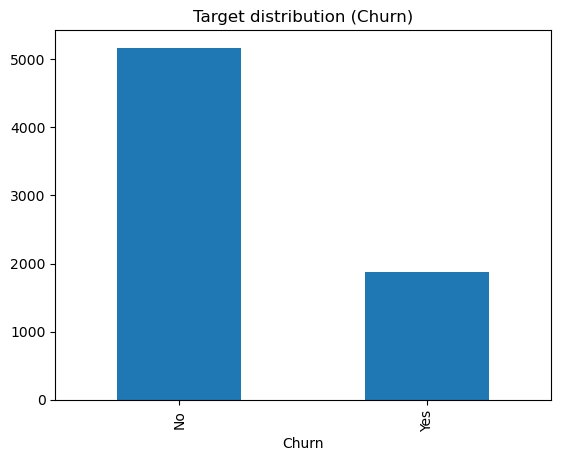

In [11]:
# Basic EDA
print('Shape:', df.shape)
print('\nMissing values per column:')
print(df.isnull().sum().sort_values(ascending=False).head(20))

print('\nColumn types:')
print(df.dtypes.value_counts())

# Quick plots for numeric features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if target in num_cols:
    num_cols = [c for c in num_cols if c != target]

print('\nNumeric columns sample:', num_cols[:10])

# Plot distribution for target if binary
try:
    df[target].value_counts().plot(kind='bar', title=f'Target distribution ({target})')
    plt.show()
except Exception as e:
    print('Could not plot target distribution:', e)

In [13]:
# Preprocessing: split features and labels, build pipeline
X = df.drop(columns=[target])
y = df[target]

# Identify column types
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numeric features:', len(numeric_features))
print('Categorical features:', len(categorical_features))

# Simple transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

try:
    # For scikit-learn >= 1.2
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # For scikit-learn < 1.2
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', onehot)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Numeric features: 3
Categorical features: 17


In [15]:
# Train-test split and Random Forest training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

print('Training Random Forest...')
rf_pipeline.fit(X_train, y_train)
print('Random Forest training complete.')

Train shape: (5634, 20) Test shape: (1409, 20)
Training Random Forest...
Random Forest training complete.


Accuracy: 0.794889992902768
Precision: 0.6501766784452296
Recall: 0.4919786096256685
F1: 0.5601217656012176
ROC AUC: 0.8231431966726085

Classification report:
               precision    recall  f1-score   support

          No       0.83      0.90      0.87      1035
         Yes       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.79      1409

Confusion matrix:
 [[936  99]
 [190 184]]


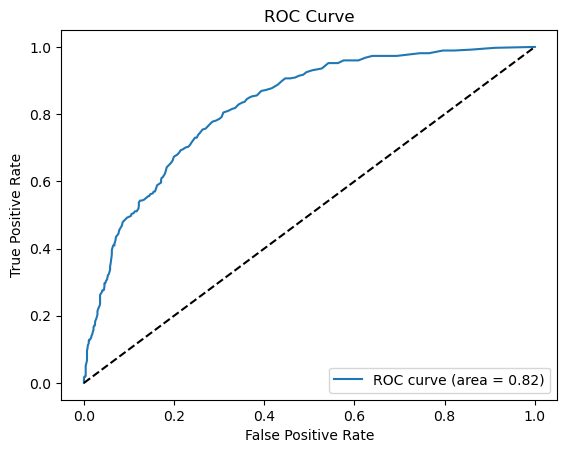

In [17]:
# Evaluation on test set
y_pred = rf_pipeline.predict(X_test)
y_proba = None
try:
    y_proba = rf_pipeline.predict_proba(X_test)[:, 1]  # probability of churn (Yes)
except:
    pass

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label="Yes", zero_division=0))
print('Recall:', recall_score(y_test, y_pred, pos_label="Yes", zero_division=0))
print('F1:', f1_score(y_test, y_pred, pos_label="Yes", zero_division=0))
if y_proba is not None:
    try:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
    except Exception as e:
        print('ROC AUC not available:', e)

print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=["No", "Yes"])
print('Confusion matrix:\n', cm)

# ROC Curve
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label="Yes")
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


Top feature importances:
 tenure                                     0.073971
MonthlyCharges                             0.055094
Contract_Month-to-month                    0.029004
OnlineSecurity_No                          0.020767
PaymentMethod_Electronic check             0.019206
InternetService_Fiber optic                0.016341
TechSupport_No                             0.016274
Contract_Two year                          0.015900
OnlineBackup_No                            0.013063
Contract_One year                          0.012170
TechSupport_Yes                            0.011450
InternetService_DSL                        0.010940
OnlineSecurity_Yes                         0.010840
PaperlessBilling_No                        0.010510
SeniorCitizen                              0.010355
PaperlessBilling_Yes                       0.010090
DeviceProtection_No                        0.009715
gender_Female                              0.009536
OnlineBackup_Yes                      

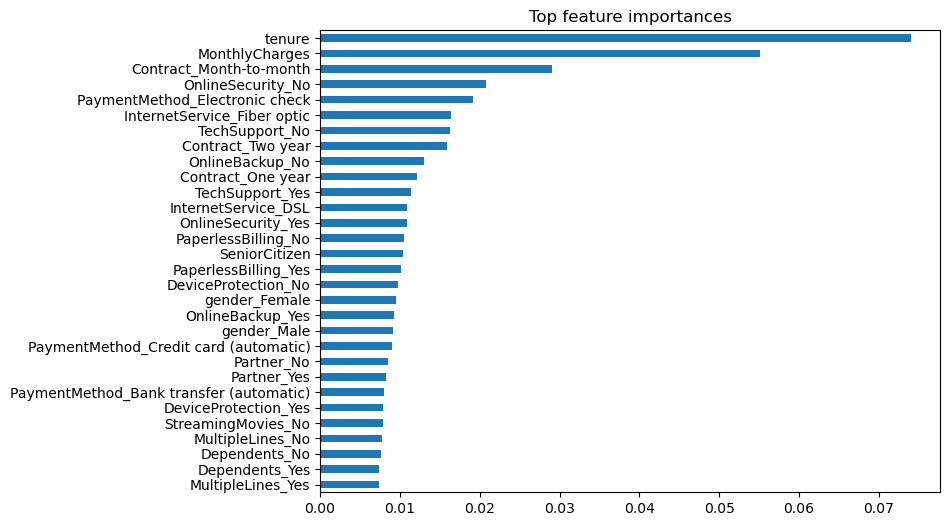

In [19]:
# Feature importance (RandomForest)
try:
    num_names = numeric_features
    cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_cols = cat_encoder.get_feature_names_out(categorical_features).tolist() if hasattr(cat_encoder, 'get_feature_names_out') else []
    feature_names = num_names + cat_cols
    importances = rf_pipeline.named_steps['classifier'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    print('Top feature importances:\n', fi)
    fi.plot(kind='barh', figsize=(8,6), title='Top feature importances'); plt.gca().invert_yaxis(); plt.show()
except Exception as e:
    print('Could not compute feature importances automatically:', e)

In [21]:
# Logistic Regression baseline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

print('Training Logistic Regression...')
lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

print('LogReg Accuracy:', accuracy_score(y_test, y_pred_lr))
print('LogReg F1:', f1_score(y_test, y_pred_lr, pos_label="Yes", zero_division=0))
print('\nClassification report:\n', classification_report(y_test, y_pred_lr, zero_division=0))


Training Logistic Regression...
LogReg Accuracy: 0.7963094393186657
LogReg F1: 0.5882352941176471

Classification report:
               precision    recall  f1-score   support

          No       0.84      0.89      0.86      1035
         Yes       0.63      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [23]:
# Save the RandomForest pipeline to disk
model_path = r"C:\Users\sarve\Downloads\churn_rf_pipeline.joblib"
joblib.dump(rf_pipeline, model_path)
print("Saved model to", model_path)

Saved model to C:\Users\sarve\Downloads\churn_rf_pipeline.joblib


In [27]:
# Load the trained model
loaded_model = joblib.load(r"C:\Users\sarve\Downloads\churn_rf_pipeline.joblib")
print("✅ Model loaded successfully")


✅ Model loaded successfully


In [31]:
import pandas as pd


new_customer = pd.DataFrame([{
    'customerID': '9999-XYZ',   # dummy ID
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 75.35,
    'TotalCharges': 850.5
}])

# Predict churn
prediction = loaded_model.predict(new_customer)[0]
probability = loaded_model.predict_proba(new_customer)[0][1]

print("Prediction:", prediction)  # 'Yes' or 'No'
print("Churn Probability:", round(probability, 3))


Prediction: Yes
Churn Probability: 0.595
